In [ ]:
# import pytesseract
# from PIL import Image, ImageDraw, ImageFont
# import numpy as np

# image = Image.open("/home/ankush.deshmukh/layout_based_classification/Train_data/aadhaar_back/0bf2d785-4ff2-4f73-8170-d530c1652df1-1.jpg")
# ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
# ocr_df = ocr_df.dropna().reset_index(drop=True)
# float_cols = ocr_df.select_dtypes('float').columns
# ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
# ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
# words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
# words


# pip install 'git+https://github.com/facebookresearch/detectron2.git'
# pip install ipywidgets
# pip install --upgrade jupyter
# pip install --upgrade tqdm
     

#encoded_inputs = processor(image, return_tensors="pt")

# for k,v in encoded_inputs.items():
#   print(k, v.shape)
#processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())



In [35]:
exp_folder_path = "/home/ankush.deshmukh/layout_based_classification/model_versions/" 
model_name = "model_feb_3_layoutlmv3_0.2"

import os

folder_path = exp_folder_path + model_name

if not os.path.exists(folder_path):
    # If not, create the folder
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")



dataset_path_train = "/home/ankush.deshmukh/layout_based_classification/Train_data"
dataset_path_test = "/home/ankush.deshmukh/layout_based_classification/Test_data"


Folder '/home/ankush.deshmukh/layout_based_classification/model_versions/model_feb_3_layoutlmv3_0.2' created.


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Returns True if CUDA is available, otherwise False
print(torch.version.cuda)

2.1.2+cu121
True
12.1


In [32]:
import os
import torch
import json
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np
from datasets import Dataset 
from transformers import AdamW
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
from transformers import LayoutLMv3ForSequenceClassification
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3Tokenizer, LayoutLMv3Processor

def get_images_labels(dataset_path):
  images = []
  labels = []
  for label_folder, _, file_names in os.walk(dataset_path):
    if label_folder != dataset_path:
      label = label_folder.split("/")[-1]
      for _, _, image_names in os.walk(label_folder):
        relative_image_names = []
        for image_file in image_names[:50]:
          relative_image_names.append(dataset_path + "/" + label + "/" + image_file)
        images.extend(relative_image_names)
        labels.extend([label] * len (relative_image_names))
  return images, labels 


def print_counts(path):
    all_classes = os.listdir(path)
    count_dict = {}
    for class_name in all_classes:
        if class_name not in count_dict:
            count_dict[class_name] =  len(os.listdir(path+"/"+class_name))
    return count_dict

def id2label_label2id(path):
    labels = [label for label in os.listdir(path)]
    id2label = {v: k for v, k in enumerate(labels)}
    label2id = {k: v for v, k in enumerate(labels)}
    return id2label,label2id

# prepare image for the model
def predict_class(path,processor,model,id2label):
  image = Image.open(path)

  encoded_inputs = processor(image, return_tensors="pt")

  # make sure all keys of encoded_inputs are on the same device as the model
  for k,v in encoded_inputs.items():
    encoded_inputs[k] = v.to(model.device)

  # forward pass
  outputs = model(**encoded_inputs)

  logits = outputs.logits

  # Convert logits to probabilities using softmax
  probabilities = softmax(logits, dim=-1)
  
  predicted_class_idx = probabilities.argmax(-1).item()
  max_value, max_index = torch.max(probabilities, dim=-1)
  try:
    pred_class =id2label[predicted_class_idx]
  except:
    pred_class =id2label[str(predicted_class_idx)]
     

  print("Predicted class:", pred_class," confidence", max_value.tolist()[0])



def train_model(model, tokenizer,processor,id2label,label2id, dataloader_train, dataloader_test, num_train_epochs ,saving_path,criterion):
    tokenizer.save_pretrained(saving_path)
    processor.save_pretrained(saving_path)

    file_path = saving_path+"/"+"id2label.json"
    with open(file_path, 'w') as json_file:
        json.dump(id2label, json_file, indent=4)  # `indent=4` makes the JSON output readable

    file_path = saving_path+"/"+"label2id.json"
    # Open the file in write mode and save the dictionary as JSON
    with open(file_path, 'w') as json_file:
        json.dump(label2id, json_file, indent=4)  # `indent=4` makes the JSON output readable

    # Track metrics
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_accuracy = 0.0  # Track the best validation accuracy
    best_epoch = -1


    # Set optimizer
    #optimizer = AdamW(model.parameters(), lr=5e-5)
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Training loop
    for epoch in range(num_train_epochs):
        print(f"Epoch {epoch + 1}/{num_train_epochs}")

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train= []

        for batch in tqdm(dataloader_train):
            # Move the batch tensors to the correct device
            batch = {k: v.to(model.device) for k, v in batch.items()}
            optimizer.zero_grad()
            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            
            #custom weights for crossentropy
            logits = outputs.logits 
            labels = batch['labels']
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            predictions = outputs.logits.argmax(-1)

            running_loss += loss.item()
            correct_train += (predictions == batch['labels']).float().sum()
            total_train += batch['labels'].size(0)
            all_labels_train.extend(batch['labels'].cpu().numpy())

            # Backward pass
            

        # Compute training loss and accuracy
        train_loss = running_loss / len(dataloader_train)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())

        print(f"Training Loss: {train_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy.item():.2f}%")

        # --- Validation Phase ---
        model.eval()
        validation_loss = 0.0
        correct_val = 0
        total_val = 0

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(dataloader_test):
                # Move the batch tensors to the correct device
                batch = {k: v.to(model.device) for k, v in batch.items()}

                # Forward pass (no gradients)
                outputs = model(**batch)
                loss = outputs.loss
                predictions = outputs.logits.argmax(-1)
                
                validation_loss += loss.item()
                correct_val += (predictions == batch['labels']).float().sum()
                total_val += batch['labels'].size(0)

                # Collect all predictions and labels for confusion matrix
                all_predictions.extend([id2label[pred] for pred in predictions.cpu().numpy()])
                all_labels.extend([id2label[label] for label in batch['labels'].cpu().numpy()])

        # Compute validation loss and accuracy
        val_loss = validation_loss / len(dataloader_test)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy.item())

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy.item():.2f}%")

        # Save the confusion matrix at best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1

            # Save the confusion matrix
            cm = confusion_matrix(all_labels, all_predictions)
            plt.figure(figsize=(10, 7))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted((list(set(label2id.keys())))), yticklabels=sorted(list(set(label2id.keys()))))
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.tight_layout()
            plt.savefig(os.path.join(saving_path, f"best_confusion_matrix.png"),dpi =300)
            plt.close()

            # Save model checkpoint when validation accuracy is the best
            model.save_pretrained(os.path.join(saving_path))
            print(f"Saved the model checkpoint for Epoch {best_epoch}")

        # Plotting after every epoch
        plt.figure(figsize=(12, 6))

        # Plot Training Loss and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(range(epoch + 1), train_losses, label='Training Loss')
        plt.plot(range(epoch + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Training Accuracy and Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(range(epoch + 1), train_accuracies, label='Training Accuracy')
        plt.plot(range(epoch + 1), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        # Save accuracy and loss metrics plot after each epoch
        plt.tight_layout()
        plt.savefig(os.path.join(saving_path, "acc_loss_metric.png"),dpi =300)
        plt.close()
    print(f"Best validation accuracy: {best_val_accuracy:.2f}% at Epoch {best_epoch}")
    
    return model
    

def load_the_model(loading_path):
  import json
  model = LayoutLMv3ForSequenceClassification.from_pretrained(loading_path)
  processor =  LayoutLMv3Processor.from_pretrained(loading_path)
  id2label = json.load(open(loading_path+"/"+"id2label.json"))
  label2id = json.load(open(loading_path+"/"+"label2id.json"))
  return model, processor, id2label, label2id

In [33]:
class_weights = {0: 3,
 1: 3,
 2:  3,
 3: 2,
 4: 2,
 5: 1,
 6: 1.5,
 7:  1,
 8: 1.5,
 9:  1,
 10: 1,
 11: 2,
 12: 1,
 13: 3,
 14: 1.5,
 15: 1.5,
 16: 1,
 17: 3,
 18: 1.5,
 19: 2,
 20: 1}


weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to("cuda")
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)

In [ ]:
print(print_counts(dataset_path_train))
print(print_counts(dataset_path_test))


id2label,label2id = id2label_label2id(dataset_path_train)

images_train,labels_train = get_images_labels(dataset_path_train)
images_test,labels_test = get_images_labels(dataset_path_test)

data_train = pd.DataFrame.from_dict({'image_path': images_train, 'label': labels_train})
data_test = pd.DataFrame.from_dict({'image_path': images_test, 'label': labels_test})

unique_labels = list(set(labels_train))
dataset_train= Dataset.from_pandas(data_train)
dataset_train = dataset_train.shuffle(seed=42)

dataset_test=Dataset.from_pandas(data_test) 


def preprocess_data(examples):
  # take a batch of images
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  # add labels
  encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]
  return encoded_inputs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMv3ForSequenceClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=len(list(set(labels_train))))
model.to(device)

## Loss function: Cross-Entropy Loss with class weights


feature_extractor = LayoutLMv3FeatureExtractor()
tokenizer = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-base")
processor= LayoutLMv3Processor(feature_extractor, tokenizer)


encoded_dataset_train = dataset_train.map(preprocess_data, remove_columns=dataset_train.column_names, batched=True, batch_size=64,num_proc = 25)
encoded_dataset_test = dataset_test.map(preprocess_data, remove_columns=dataset_test.column_names,  batched=True, batch_size=64,num_proc = 25)
encoded_dataset_train.set_format(type="torch", device="cuda")
encoded_dataset_test.set_format(type="torch", device="cuda")


dataloader_train = torch.utils.data.DataLoader(encoded_dataset_train, batch_size=16,shuffle =True)
dataloader_test = torch.utils.data.DataLoader(encoded_dataset_test, batch_size=16)


{'photograph': 100, 'passport_back': 100, 'cheques': 100, 'voter_back': 100, 'DL': 100, 'mri_report': 100, 'voter_front': 100, 'aadhaar_full': 100, 'passbook': 100, 'cowin': 100, 'usg_report': 100, 'aadhaar_front': 100, 'payslip': 100, 'passport_front': 100, 'pan': 100, 'aadhaar_back': 100, 'itr': 100, 'angiogram': 100, 'death_certificate': 100, 'birth_certificate': 100, 'xray_report': 100}
{'photograph': 10, 'passport_back': 10, 'cheques': 10, 'voter_back': 10, 'DL': 10, 'mri_report': 5, 'voter_front': 10, 'aadhaar_full': 10, 'passbook': 10, 'cowin': 10, 'usg_report': 5, 'aadhaar_front': 10, 'payslip': 10, 'passport_front': 10, 'pan': 10, 'aadhaar_back': 10, 'itr': 10, 'angiogram': 10, 'death_certificate': 10, 'birth_certificate': 10, 'xray_report': 5}


Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


Map (num_proc=25):   0%|          | 0/1050 [00:00<?, ? examples/s]

Map (num_proc=25):   0%|          | 0/195 [00:00<?, ? examples/s]

In [38]:
saving_path = exp_folder_path + model_name
num_train_epochs = 50
# model = train_model(model, tokenizer,processor,id2label,label2id, dataloader_train, dataloader_test, num_train_epochs ,saving_path)
model = train_model(model, tokenizer,processor,id2label,label2id, dataloader_train, dataloader_test, num_train_epochs ,saving_path,criterion)

Epoch 1/50


100%|██████████| 66/66 [03:08<00:00,  2.85s/it]


Training Loss: 2.6865
Training Accuracy: 13.33%


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Validation Loss: 2.6382
Validation Accuracy: 16.41%
Saved the model checkpoint for Epoch 1
Epoch 2/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:08<00:00,  2.85s/it]


Training Loss: 2.2050
Training Accuracy: 25.62%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 2.3891
Validation Accuracy: 20.51%
Saved the model checkpoint for Epoch 2
Epoch 3/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 1.8575
Training Accuracy: 35.14%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 1.9101
Validation Accuracy: 36.92%
Saved the model checkpoint for Epoch 3
Epoch 4/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:05<00:00,  2.82s/it]


Training Loss: 1.4034
Training Accuracy: 51.24%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 1.5924
Validation Accuracy: 45.13%
Saved the model checkpoint for Epoch 4
Epoch 5/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.9640
Training Accuracy: 69.33%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 1.2166
Validation Accuracy: 65.13%
Saved the model checkpoint for Epoch 5
Epoch 6/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.7601
Training Accuracy: 75.14%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 1.0867
Validation Accuracy: 66.15%
Saved the model checkpoint for Epoch 6
Epoch 7/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:06<00:00,  2.82s/it]


Training Loss: 0.5237
Training Accuracy: 83.71%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 1.3479
Validation Accuracy: 57.95%
Epoch 8/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.4005
Training Accuracy: 86.76%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.7341
Validation Accuracy: 77.44%
Saved the model checkpoint for Epoch 8
Epoch 9/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:07<00:00,  2.85s/it]


Training Loss: 0.1888
Training Accuracy: 94.29%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.6877
Validation Accuracy: 79.49%
Saved the model checkpoint for Epoch 9
Epoch 10/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:08<00:00,  2.86s/it]


Training Loss: 0.1184
Training Accuracy: 96.10%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5548
Validation Accuracy: 83.08%
Saved the model checkpoint for Epoch 10
Epoch 11/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0775
Training Accuracy: 97.71%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5797
Validation Accuracy: 84.62%
Saved the model checkpoint for Epoch 11
Epoch 12/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:07<00:00,  2.85s/it]


Training Loss: 0.0476
Training Accuracy: 99.05%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5596
Validation Accuracy: 85.13%
Saved the model checkpoint for Epoch 12
Epoch 13/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:05<00:00,  2.82s/it]


Training Loss: 0.0449
Training Accuracy: 98.48%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5147
Validation Accuracy: 87.18%
Saved the model checkpoint for Epoch 13
Epoch 14/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0293
Training Accuracy: 99.52%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5184
Validation Accuracy: 86.67%
Epoch 15/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0231
Training Accuracy: 99.81%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5064
Validation Accuracy: 87.69%
Saved the model checkpoint for Epoch 15
Epoch 16/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0220
Training Accuracy: 99.71%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5301
Validation Accuracy: 87.18%
Epoch 17/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0190
Training Accuracy: 99.81%


100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Validation Loss: 0.5376
Validation Accuracy: 87.18%
Epoch 18/50


100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.0168
Training Accuracy: 99.71%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5070
Validation Accuracy: 87.18%
Epoch 19/50


100%|██████████| 66/66 [03:10<00:00,  2.88s/it]


Training Loss: 0.0218
Training Accuracy: 99.43%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5146
Validation Accuracy: 88.72%
Saved the model checkpoint for Epoch 19
Epoch 20/50


  0%|          | 0/66 [00:00<?, ?it/s]/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 66/66 [03:08<00:00,  2.85s/it]


Training Loss: 0.0225
Training Accuracy: 99.52%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.6007
Validation Accuracy: 85.13%
Epoch 21/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.1419
Training Accuracy: 96.00%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 1.2595
Validation Accuracy: 66.15%
Epoch 22/50


100%|██████████| 66/66 [03:06<00:00,  2.82s/it]


Training Loss: 0.6523
Training Accuracy: 80.86%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.8379
Validation Accuracy: 76.41%
Epoch 23/50


100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.4754
Training Accuracy: 86.29%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.8499
Validation Accuracy: 75.90%
Epoch 24/50


100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.2773
Training Accuracy: 92.19%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.7660
Validation Accuracy: 77.44%
Epoch 25/50


100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.1219
Training Accuracy: 96.95%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.6323
Validation Accuracy: 80.51%
Epoch 26/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0585
Training Accuracy: 98.57%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.6402
Validation Accuracy: 82.05%
Epoch 27/50


100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.0260
Training Accuracy: 99.33%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.6107
Validation Accuracy: 85.13%
Epoch 28/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0092
Training Accuracy: 99.90%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5661
Validation Accuracy: 84.62%
Epoch 29/50


100%|██████████| 66/66 [03:06<00:00,  2.82s/it]


Training Loss: 0.0082
Training Accuracy: 99.90%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5425
Validation Accuracy: 85.13%
Epoch 30/50


100%|██████████| 66/66 [03:08<00:00,  2.86s/it]


Training Loss: 0.0071
Training Accuracy: 99.90%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5509
Validation Accuracy: 85.64%
Epoch 31/50


100%|██████████| 66/66 [03:08<00:00,  2.86s/it]


Training Loss: 0.0066
Training Accuracy: 99.81%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5478
Validation Accuracy: 85.64%
Epoch 32/50


100%|██████████| 66/66 [03:07<00:00,  2.85s/it]


Training Loss: 0.0055
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5509
Validation Accuracy: 85.64%
Epoch 33/50


100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.0048
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


Validation Loss: 0.5624
Validation Accuracy: 85.64%
Epoch 34/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0048
Training Accuracy: 99.90%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5130
Validation Accuracy: 86.67%
Epoch 35/50


100%|██████████| 66/66 [03:09<00:00,  2.87s/it]


Training Loss: 0.0053
Training Accuracy: 99.90%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5302
Validation Accuracy: 86.67%
Epoch 36/50


100%|██████████| 66/66 [03:31<00:00,  3.21s/it]


Training Loss: 0.0040
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5393
Validation Accuracy: 86.15%
Epoch 37/50


100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.0102
Training Accuracy: 99.62%


100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


Validation Loss: 0.5252
Validation Accuracy: 86.67%
Epoch 38/50


100%|██████████| 66/66 [03:36<00:00,  3.28s/it]


Training Loss: 0.0037
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5282
Validation Accuracy: 86.67%
Epoch 39/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0031
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5294
Validation Accuracy: 87.69%
Epoch 40/50


100%|██████████| 66/66 [03:16<00:00,  2.98s/it]


Training Loss: 0.0029
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5304
Validation Accuracy: 87.18%
Epoch 41/50


100%|██████████| 66/66 [03:19<00:00,  3.02s/it]


Training Loss: 0.0027
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5332
Validation Accuracy: 88.21%
Epoch 42/50


100%|██████████| 66/66 [03:23<00:00,  3.08s/it]


Training Loss: 0.0026
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5347
Validation Accuracy: 87.69%
Epoch 43/50


100%|██████████| 66/66 [03:08<00:00,  2.86s/it]


Training Loss: 0.0024
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5358
Validation Accuracy: 87.69%
Epoch 44/50


100%|██████████| 66/66 [03:10<00:00,  2.89s/it]


Training Loss: 0.0023
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5320
Validation Accuracy: 87.69%
Epoch 45/50


100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.0022
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5369
Validation Accuracy: 87.69%
Epoch 46/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0020
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5359
Validation Accuracy: 87.69%
Epoch 47/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0020
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5382
Validation Accuracy: 87.69%
Epoch 48/50


100%|██████████| 66/66 [03:07<00:00,  2.84s/it]


Training Loss: 0.0019
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


Validation Loss: 0.5412
Validation Accuracy: 88.21%
Epoch 49/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0018
Training Accuracy: 100.00%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.5433
Validation Accuracy: 87.69%
Epoch 50/50


100%|██████████| 66/66 [03:06<00:00,  2.83s/it]


Training Loss: 0.0175
Training Accuracy: 99.71%


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Validation Loss: 0.6187
Validation Accuracy: 85.13%
Best validation accuracy: 88.72% at Epoch 19


In [21]:
path = "/home/ankush.deshmukh/layout_based_classification/model_versions/model_feb_2_0.2"
loaded_model,loaded_processor,loaded_id2label, loaded_label2id = load_the_model(path)
img_path ="/home/ankush.deshmukh/image_classification/dummy_test_set/pan/0d7a8320-ccd3-4e9b-b07b-4c821cd9e1db-1.jpg"
predict_class(img_path,loaded_processor,loaded_model,loaded_id2label)

Predicted class: itr  confidence 0.05767662823200226


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


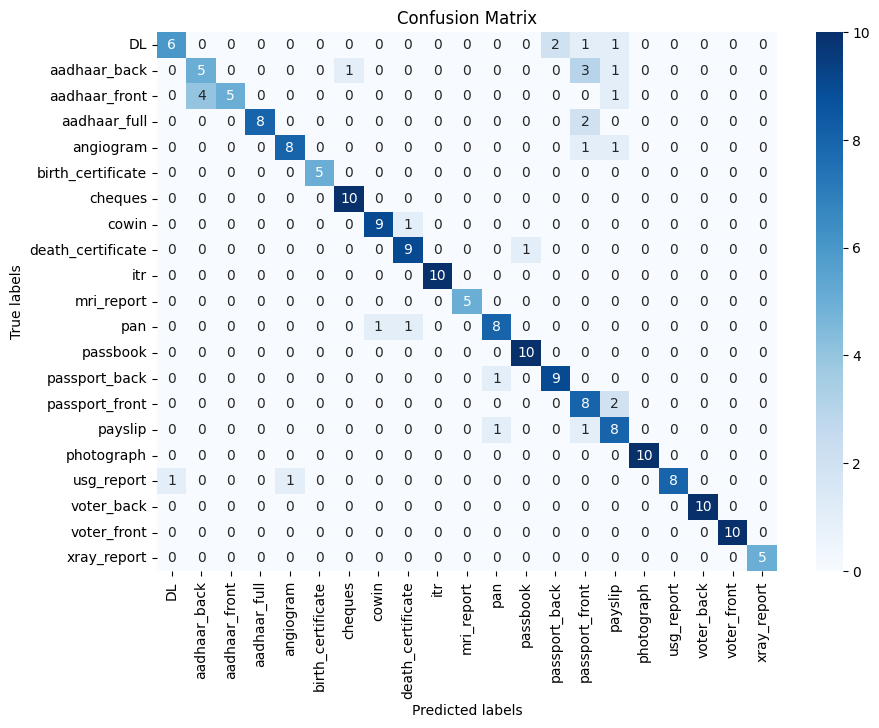

In [39]:
import torch
from transformers import LayoutLMv2ForSequenceClassification, LayoutLMv2Processor
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
path = "/home/ankush.deshmukh/layout_based_classification/model_versions/model_feb_3_layoutlmv3_0.2"
loaded_model,loaded_processor,loaded_id2label, loaded_label2id  = load_the_model(path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
unique_labels = list(label2id.keys())
# Put the model in evaluation mode
model.eval()

# Initialize the DataLoader for the test dataset
# Assuming your test dataset is in 'dataloader_test'
all_predictions = []
all_labels = []

# Inference on the test dataset
with torch.no_grad():  # Disable gradient calculation during inference
    for batch in tqdm(dataloader_test):
        # Forward pass (inference)
        outputs = model(**batch)
        
        # Get the predicted class (with highest logits)
        predictions = outputs.logits.argmax(-1)
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(unique_labels), yticklabels=sorted(unique_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
#plt.savefig("/home/ankush.deshmukh/layout_based_classification/metric/feb_1_confusion_matrix.png")  # Save the confusion matrix as an image
plt.show()  # Optionally show the plot

#print("Confusion matrix saved as 'confusion_matrix.png'.")
